## Working with OOI JSON Data

In this example we will learn how to programatically download and work with OOI JSON data from within the notebook. We will use data from the 3D Thermistory Array deployed in the ASHES Vent field at Axial Seamount for this example, but the mechanics apply to all datasets that are processed through the OOI Cyberinfrastructure (CI) system. You wil learn:

* how to find the data you are looking for
* how to use the machine to machine API to request JSON data
* how to explore and plot data

The difference between a NetCDF and JSON data request is that NetCDF files are served asynchronously and delivered to a THREDDS server, while the JSON data response is synchronous (instantaneous) and served as a JSON object in the GET response. NetCDF data is undecimated (full data set), while the JSON response is decimated down to a maximum of 20,000 data points.

If you get stuck for whatever reason using the notebook, please send us a note on slack.

### Part One: Finding and requesting the data.

In [1]:
import requests
import datetime

The ingredients being used to build the data_request_url can be found here. For this example, we will use the data from the 3D Thermistor Array (TMPSF) http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-07-TMPSFA301

In [2]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'
beginDT = '2017-09-04T10:01:01.000Z'
# beginDT = (datetime.datetime.utcnow() - datetime.timedelta(days=2)).strftime("%Y-%m-%dT%H:%M:%S.000Z")
endDT = '2017-09-05T10:01:01.000Z'

Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner).

In [3]:
username = ''
token = ''

Optionally, you can handle authentication outside the notebook by setting up a .netrc file in your home directory and loading it with your bash profile. To save time, we will not go through this personalized setup during the tutorial, but can help individuals get this set up during hacking.

In [4]:
# import netrc
# netrc = netrc.netrc()
# remoteHostName = "ooinet.oceanobservatories.org"
# info = netrc.authenticators(remoteHostName)
# username = info[0]
# token = info[2]

Send the data request.

In [5]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,
    'limit':20000,   
}

r = requests.get(data_request_url, params=params,auth=(username, token))
data = r.json()

How many data points are in the response?

In [6]:
len(data)

8640

What is returned the first data point?

In [7]:
data[0]

{u'battery_voltage': 12.000300407409668,
 u'driver_timestamp': 3713508070.591078,
 u'ingestion_timestamp': 3713508073.55,
 u'internal_timestamp': 3157435800.0,
 u'pk': {u'deployment': 3,
  u'method': u'streamed',
  u'node': u'MJ03B',
  u'sensor': u'07-TMPSFA301',
  u'stream': u'tmpsf_sample',
  u'subsite': u'RS03ASHS',
  u'time': 3713508070.3271585},
 u'port_timestamp': 3713508070.3271585,
 u'preferred_timestamp': u'port_timestamp',
 u'serial_number': u'021969',
 u'temperature01': 5.816299915313721,
 u'temperature01_qc_executed': 29,
 u'temperature01_qc_results': 29,
 u'temperature02': 2.5889999866485596,
 u'temperature02_qc_executed': 29,
 u'temperature02_qc_results': 29,
 u'temperature03': 3.5064001083374023,
 u'temperature03_qc_executed': 29,
 u'temperature03_qc_results': 29,
 u'temperature04': 2.6410000324249268,
 u'temperature04_qc_executed': 29,
 u'temperature04_qc_results': 29,
 u'temperature05': 5.854599952697754,
 u'temperature05_qc_executed': 29,
 u'temperature05_qc_results':

## Part Two: Exploring the data.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import netCDF4 as nc
import numpy as np

Time stamps are returned as seconds since 1900-01-01. `nc.num2date(timstamp,'seconds since 1900-01-01')` allows for a quick conversion.

In [9]:
time = []
temperature01 = []

for i in range(len(data)):
    time.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01').replace(microsecond=0))
    temperature01.append(data[i]['temperature01'])

A quick plot shows what appears to be a tidally influenced temperature signal.

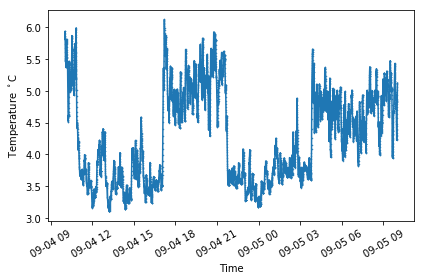

In [10]:
plt.plot(time, temperature01, marker=".", markersize=1, linestyle=None)
plt.ylabel('Temperature $^\circ$C')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Adding in another measurements from another thermistor we can nicely see that the diffuse fluid might be wafting back and for accross the 3D array with the tidal current.

In [11]:
temperature03 = []
for i in range(len(data)):
    temperature03.append(data[i]['temperature03'])

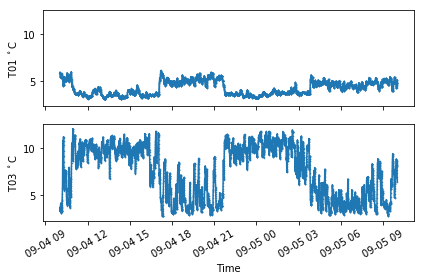

In [12]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(time, temperature01, marker=".", markersize=1, linestyle=None)
ax2.plot(time, temperature03, marker=".", markersize=1, linestyle=None)
ax1.set_ylabel('T01 $^\circ$C')
ax2.set_ylabel('T03 $^\circ$C')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.tight_layout()
# fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

Finally, we can pull in some pressure data for a closer look at the tidal relationship.

In [13]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '09-BOTPTA304'
method = 'streamed'
stream = 'botpt_nano_sample'
beginDT = '2017-09-04T10:01:01.000Z'
endDT = '2017-09-05T10:01:01.000Z'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,
    'limit':8640,   
}

r = requests.get(data_request_url, params=params,auth=(username, token))
data = r.json()

Extract the pressure variable from the response and convert the time stamps

In [14]:
botpt_time = []
bottom_pressure = []
for i in range(len(data)):
    botpt_time.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01').replace(microsecond=0))
    bottom_pressure.append(data[i]['bottom_pressure'])

Plot co-located temperature 01, 03 and bottom pressure.

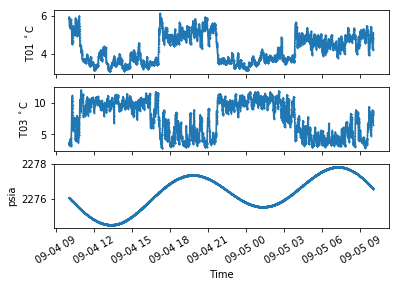

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)
ax1.plot(time, temperature01, marker=".", markersize=1, linestyle=None)
ax2.plot(time, temperature03, marker=".", markersize=1, linestyle=None)
ax3.plot(botpt_time, bottom_pressure, marker=".", markersize=1, linestyle=None)
ax1.set_ylabel('T01 $^\circ$C')
ax2.set_ylabel('T03 $^\circ$C')
ax3.set_ylabel('psia')
plt.xlabel('Time')
plt.xticks(rotation=30)
# plt.tight_layout()
# fig.subplots_adjust(hspace=0)
# plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()